# Model 7: Migration

Original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model7.html

## Note
- 遺伝的進化と同様、文化的進化の基本的推進力は、選択、変異、ドリフト、移動 (Migration) である。
- 集団から集団への人の移動は、集団間の文化の多様性を形成し、有益な技術やアイデアを集団から集団へ広めることができる。
- Model 7 では、グループ間移動に伴って、グループ間の文化的多様性がどの様に変化するかを見ていく。
- エージェントは A / B の特性を持つが、特性間のバイアスは存在しない。
- Each agent has a probability $m$ of migrating.
    - First, each agent migrates with probability $m$, ignoring group membership. On average, this gives $2Nm$ migrants across the entire population.
    - We take the migrants out of their groups, leaving empty slots where they used to be.
    - Then we put these migrants back into the empty slots at random, ignoring which group the slot is in.
    - This keeps $N$ constant: for every empty slot, there is a migrating agent.
    - Some might go back into their original group, but this won’t change anything so it doesn’t really matter.

In [1]:
include("src/Agent.jl")
include("src/Output.jl")
using .Agent
using .Output

using DataFrames

In [2]:
function make_agent_df(N::Int, p_0::Float64, q_0::Float64)::DataFrame
    traits1 = [rand() < p_0 ? A : B for _ in 1:N]
    traits2 = [rand() < q_0 ? A : B for _ in 1:N]
    traits = vcat(traits1, traits2)
    groups = vcat(fill(1, N), fill(2, N))

    return DataFrame(trait = traits, group = groups)
end

function trait_ratio(agent_df::DataFrame, trait::Agent.Trait, group::Int)::Float64
    _df = agent_df[agent_df.group.==group, :]
    trait_count = nrow(_df[_df.trait.==trait, :])

    return trait_count / nrow(_df)
end

trait_ratio (generic function with 1 method)

In [3]:
function migration(; N::Int64, r_max::Int64, t_max::Int64, p_0:: Float64, q_0:: Float64, m::Float64)
    output_df = make_output_df(r_max, t_max)

    for r = 1:r_max
        agent_df = make_agent_df(N, p_0, q_0)

        for t = 1:t_max
            if t > 1
                # migration:
                probabilities = rand(2N)
                migrants = agent_df[probabilities .< m, :].trait
                agent_df[probabilities .< m, :trait] = rand(migrants, length(migrants))
            end

            row_num = t + (r - 1) * t_max
            output_df.r[row_num] = r
            output_df.t[row_num] = t
            output_df.p[row_num] = trait_ratio(agent_df, A, 1)
            output_df.q[row_num] = trait_ratio(agent_df, A, 2)
        end
    end

    plot_A_X(output_df, "N = $N, m = $m")
end;

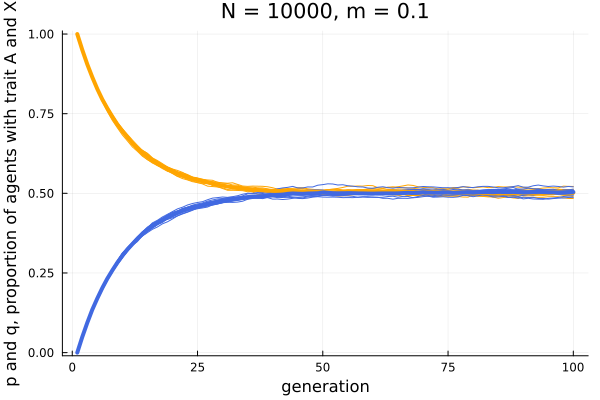

In [4]:
migration(N = 10^4, r_max = 10, t_max = 100, p_0 = 1.0, q_0 = 0.0, m = 0.1)

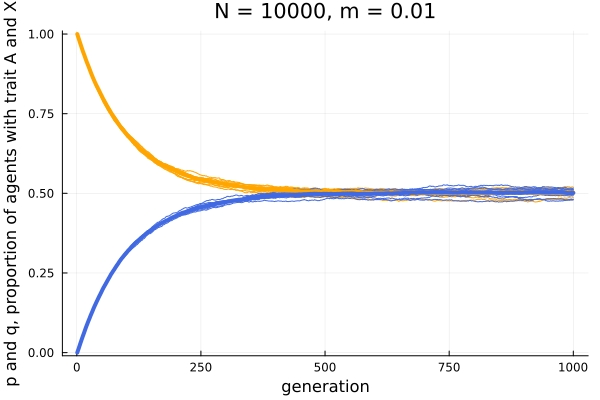

In [5]:
migration(N = 10^4, r_max = 10, t_max = 1000, p_0 = 1.0, q_0 = 0.0, m = 0.01)

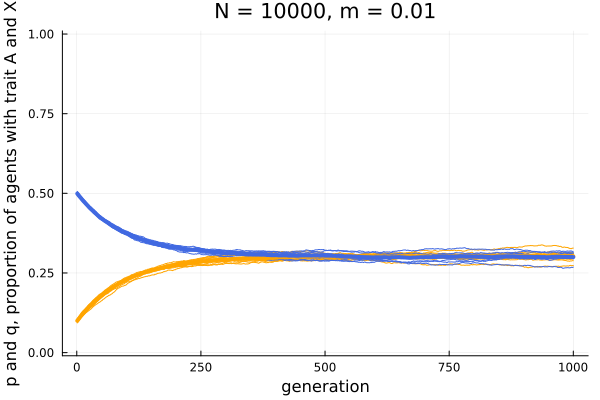

In [6]:
migration(N = 10^4, r_max = 10, t_max = 1000, p_0 = 0.1, q_0 = 0.5, m = 0.01)

## Note
- This consequence of migration, to break down between-group differences and make each group identical, is well known from population genetics.
- In order to maintain between-group variation in the face of even small amounts of migration, we therefore need some additional process.

## Model 7b: Migration and biased transmission

In [7]:
function migration(; N::Int64, r_max::Int64, t_max::Int64, p_0:: Float64, q_0:: Float64, m::Float64, s::Float64)
    # s: the strength of this biased transmission
    output_df = make_output_df(r_max, t_max)

    for r = 1:r_max
        agent_df = make_agent_df(N, p_0, q_0)

        for t = 1:t_max
            if t > 1
                # migration:
                migration_probabilities = rand(2N)
                migrants = agent_df[migration_probabilities .< m, :].trait
                agent_df[migration_probabilities .< m, :trait] = rand(migrants, length(migrants))
                
                # group 1 favours A:
                traits1 = agent_df[agent_df.group .== 1, :trait]
                demonstrator1 = rand(traits1, length(traits1))
                agent_df[agent_df.group .== 1, :trait] = [(d == A && s > rand()) ? A : t for (t, d) in zip(traits1, demonstrator1)]

                # group 2 favours B:
                traits2 = agent_df[agent_df.group .== 2, :trait]
                demonstrator2 = rand(traits2, length(traits2))
                agent_df[agent_df.group .== 2, :trait] = [(d == B && s > rand()) ? B : t for (t, d) in zip(traits2, demonstrator2)]
            end

            row_num = t + (r - 1) * t_max
            output_df.r[row_num] = r
            output_df.t[row_num] = t
            output_df.p[row_num] = trait_ratio(agent_df, A, 1)
            output_df.q[row_num] = trait_ratio(agent_df, A, 2)
        end
    end

    plot_A_X(output_df, "N = $N, m = $m")
end

migration (generic function with 1 method)

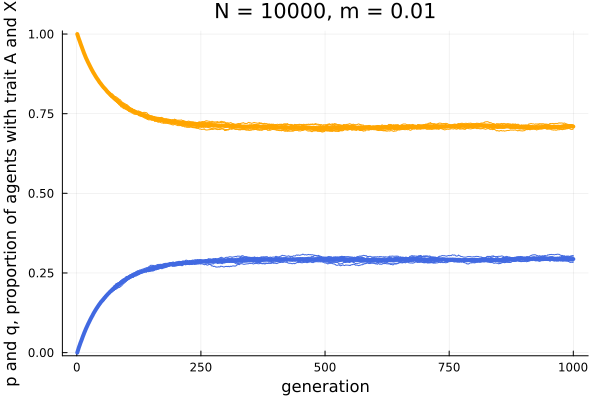

In [8]:
migration(N = 10^4, r_max = 10, t_max = 1000, p_0 = 1.0, q_0 = 0.0, m = 0.01, s = 0.01)

## Model 7c: Migration and conformist transmission

r = 1
r = 2
r = 3
r = 4
r = 5
r = 6
r = 7
r = 8
r = 9
r = 10


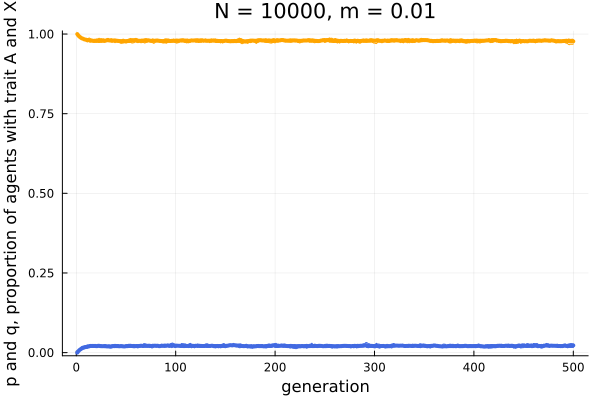

In [14]:
function get_new_trait1(agents_df::DataFrame, D::Float64)::Agent.Trait
    demonstrators = rand(agents_df.trait, 3)
    A_count = count(demonstrators .== A)

    # 次のTraitがAになる確率
    prob = if A_count == 3
        1.0
    elseif A_count == 2
        2/3 + D/3
    elseif A_count == 1
        1/3 - D/3
    else
        0.0
    end

    return prob > rand() ? A : B
end

function get_new_trait2(agents_df::DataFrame, D::Float64)::Agent.Trait
    demonstrators = rand(agents_df.trait, 3)
    A_count = count(demonstrators .== A)

    # 次のTraitがAになる確率
    prob = if A_count == 3
        0.0
    elseif A_count == 2
        1/3 + D/3
    elseif A_count == 1
        2/3 - D/3
    else
        1.0
    end

    return prob > rand() ? A : B
end

function migration(; N::Int64, r_max::Int64, t_max::Int64, p_0:: Float64, q_0:: Float64, m::Float64, D::Float64)    
    output_df = make_output_df(r_max, t_max)

    for r = 1:r_max
        @show r
        agent_df = make_agent_df(N, p_0, q_0)

        for t = 1:t_max
            if t > 1
                # migration:
                probabilities = rand(2N)
                migrants = agent_df[probabilities .< m, :].trait
                agent_df[probabilities .< m, :trait] = rand(migrants, length(migrants))
                
                # conformity in group 1:
                _df = agent_df[agent_df.group .== 1, :]
                agent_df[agent_df.group .== 1, :trait] = [get_new_trait1(_df, D) for _ in 1:N]
                
                # conformity in group 2:
                _df = agent_df[agent_df.group .== 2, :]
                agent_df[agent_df.group .== 2, :trait] = [get_new_trait1(_df, D) for _ in 1:N]
            end

            row_num = t + (r - 1) * t_max
            output_df.r[row_num] = r
            output_df.t[row_num] = t
            output_df.p[row_num] = trait_ratio(agent_df, A, 1)
            output_df.q[row_num] = trait_ratio(agent_df, A, 2)
        end
    end

    plot_A_X(output_df, "N = $N, m = $m")
end

migration(N = 10^4, r_max = 10, t_max = 500, p_0 = 1.0, q_0 = 0.0, m = 0.01, D = 0.2)